In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
from joblib import parallel_backend

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from chesswinnerprediction.baseline.utils import get_x_and_y, get_class_weights, print_report, show_feature_importance, transform_and_scale_df
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH

In [31]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [32]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [33]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scale=False)

In [34]:
class_weights = get_class_weights(train_df["Result"], verbose=True)

Class weights:
	1-0: 0.6718789964523187
	0-1: 0.6971858059373535
	1/2-1/2: 12.936795431862432


In [35]:
x_train_data, y_train = get_x_and_y(train_data, predict_draws=True)
x_valid_data, y_valid = get_x_and_y(valid_data, predict_draws=True)

## Random Forest

In [36]:
random_forest_params = {
    "n_estimators": [24, 32, 56],
    "max_depth": [10, 11, 12],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [7e-5, 13e-5, 25e-5, 50e-5],
    "min_samples_leaf": [1e-5, 3e-5, 8e-5, 12e-5],
    "min_impurity_decrease": [5e-6, 1e-5, 1e-4, 2e-4],
    "min_weight_fraction_leaf": [0.0, 1e-5, 2e-5, 5e-5],
    "max_leaf_nodes": [None, 350, 400, 450],
}

forest_clf = RandomForestClassifier(class_weight=class_weights, verbose=0, n_jobs=-1, random_state=BASELINE_RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=forest_clf, 
    param_distributions=random_forest_params,
    n_iter=3,
    cv=5,
    verbose=4, 
    random_state=BASELINE_RANDOM_STATE, 
    scoring="recall_macro", 
    return_train_score=True,
)

In [37]:
random_search.fit(x_train_data, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END max_depth=10, max_features=0.5, min_impurity_decrease=5e-06, min_samples_leaf=3e-05, min_samples_split=0.0005, min_weight_fraction_leaf=2e-05, n_estimators=56;, score=(train=0.489, test=0.472) total time=  15.0s
[CV 2/5] END max_depth=10, max_features=0.5, min_impurity_decrease=5e-06, min_samples_leaf=3e-05, min_samples_split=0.0005, min_weight_fraction_leaf=2e-05, n_estimators=56;, score=(train=0.488, test=0.469) total time=  14.9s
[CV 3/5] END max_depth=10, max_features=0.5, min_impurity_decrease=5e-06, min_samples_leaf=3e-05, min_samples_split=0.0005, min_weight_fraction_leaf=2e-05, n_estimators=56;, score=(train=0.489, test=0.471) total time=  14.7s
[CV 4/5] END max_depth=10, max_features=0.5, min_impurity_decrease=5e-06, min_samples_leaf=3e-05, min_samples_split=0.0005, min_weight_fraction_leaf=2e-05, n_estimators=56;, score=(train=0.489, test=0.468) total time=  14.8s
[CV 5/5] END max_depth=10, max_features=

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={'0-1': np.float64(0.6971858059373535),
                                                                  '1-0': np.float64(0.6718789964523187),
                                                                  '1/2-1/2': np.float64(12.936795431862432)},
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=3,
                   param_distributions={'max_depth': [10, 11, 12],
                                        'max_features': ['sqrt', 0.5],
                                        'min_impurity_decrease': [5e-06, 1e-05,
                                                                  0.0001,
                                                                  0.0002],
                                        'min_samples_leaf': [1e-05, 3e-05,
                                                             8e-05, 0.00012],
                                        'min_samples_split': [7e-05, 0.00013,
                                                              0.00025, 0.0005],
                                        'min_weight_fraction_leaf': [0.0, 1e-05,
                                                                     2e-05,
                                                                     5e-05],
                                        'n_estimators': [24, 32, 56]},
                   random_state=42, return_train_score=True,
                   scoring='recall_macro', verbose=4)

In [38]:
df_results = pd.DataFrame(random_search.cv_results_)
df_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_features,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.841973,0.087768,0.971025,0.011107,56,0.00002,0.00050,0.00003,0.000005,0.5,...,0.470053,0.001332,1,0.488550,0.488106,0.488917,0.489277,0.488581,0.488686,0.000392
1,4.686778,0.120425,0.961815,0.091318,32,0.00001,0.00025,0.00008,0.000200,sqrt,...,0.463368,0.002494,3,0.464797,0.464383,0.466527,0.466909,0.461131,0.464749,0.002052
2,10.010435,0.437768,1.068839,0.121342,56,0.00002,0.00013,0.00001,0.000005,sqrt,...,0.469092,0.001605,2,0.498731,0.498964,0.498726,0.498984,0.498327,0.498746,0.000237


In [39]:
sorted_df = df_results.sort_values(by="mean_test_score")
sorted_df[["params", "mean_test_score", "rank_test_score"]].head()

,params,mean_test_score,rank_test_score
1,"{'n_estimators': 32, 'min_weight_fraction_leaf...",0.463368,3
2,"{'n_estimators': 56, 'min_weight_fraction_leaf...",0.469092,2
0,"{'n_estimators': 56, 'min_weight_fraction_leaf...",0.470053,1


In [40]:
param_cols = [col for col in sorted_df.columns if col.startswith("param_")]
worst_params = sorted_df[param_cols + ["mean_test_score"]].groupby(param_cols).mean().sort_values(by="mean_test_score")
worst_params.head()

mean_test_score
param_n_estimators param_min_weight_fraction_leaf param_min_samples_split param_min_samples_leaf param_min_impurity_decrease param_max_features param_max_depth                 
32                 0.00001                        0.00025                 0.00008                0.000200                    sqrt               12                      0.463368
56                 0.00002                        0.00013                 0.00001                0.000005                    sqrt               12                      0.469092
                                                  0.00050                 0.00003                0.000005                    0.5                10                      0.470053

In [41]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

best_forest_clf = random_search.best_estimator_

Best Score: 0.4700525651841515
Best Parameters: {'n_estimators': 56, 'min_weight_fraction_leaf': 2e-05, 'min_samples_split': 0.0005, 'min_samples_leaf': 3e-05, 'min_impurity_decrease': 5e-06, 'max_features': 0.5, 'max_depth': 10}


In [42]:
best_forest_clf.fit(x_train_data, y_train)

RandomForestClassifier(class_weight={'0-1': np.float64(0.6971858059373535),
                                     '1-0': np.float64(0.6718789964523187),
                                     '1/2-1/2': np.float64(12.936795431862432)},
                       max_depth=10, max_features=0.5,
                       min_impurity_decrease=5e-06, min_samples_leaf=3e-05,
                       min_samples_split=0.0005, min_weight_fraction_leaf=2e-05,
                       n_estimators=56, n_jobs=-1, random_state=42)

In [53]:
# print n leavs in 0 estimator
best_forest_clf.estimators_[0].get_n_leaves()

np.int64(432)

In [44]:
print_report(best_forest_clf, x_train_data, y_train, x_valid_data, y_valid)

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.60      0.46      0.52    378036              0.59      0.46      0.52     45521
         1-0       0.62      0.42      0.50    392275              0.62      0.42      0.50     47220
     1/2-1/2       0.05      0.57      0.09     20373              0.05      0.53      0.09      2522
    accuracy                           0.45    790684                                  0.44     95263
   macro avg       0.42      0.48      0.37    790684              0.42      0.47      0.37     95263
weighted avg       0.59      0.45      0.50    790684              0.59      0.44      0.50     95263
       


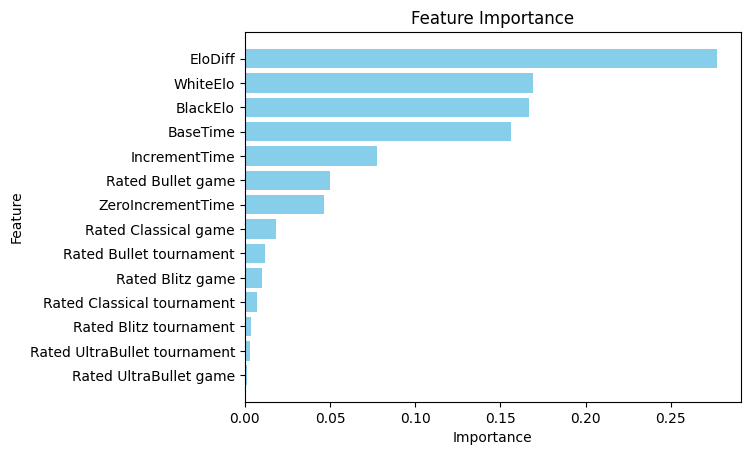

In [117]:
show_feature_importance(best_forest_clf, best_forest_clf.feature_importances_)

## Gradient Boosting

In [144]:
gradient_boosting_params = {
    "n_estimators": [3, 5, 8, 10, 15, 20],
    "max_depth": [2, 3, 4],
    "max_features": ["sqrt", 0.5],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    # "min_samples_split": [3e-5, 7e-5, 13e-5, 25e-5],
    # "min_samples_leaf": [1e-5, 3e-5, 8e-5, 12e-5],
    # "min_impurity_decrease": [1e-5, 1e-4, 2e-4],
    # "min_weight_fraction_leaf": [0.0, 1e-4, 2e-4, 5e-4],
}

boosting_clf = GradientBoostingClassifier(verbose=0, validation_fraction=0.0)

random_search = RandomizedSearchCV(
    estimator=boosting_clf,
    param_distributions=gradient_boosting_params,
    n_iter=10,
    cv=5,
    verbose=3,
    random_state=42,
    scoring="recall_macro",
    return_train_score=True,
    # pre_dispatch=7,
    n_jobs=2,
)

In [145]:
with parallel_backend("multiprocessing"):
    random_search.fit(x_train_data, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END max_depth=2, max_features=sqrt, n_estimators=3;, score=(train=0.380, test=0.379) total time=   3.1s
[CV 1/5] END max_depth=2, max_features=sqrt, n_estimators=3;, score=(train=0.380, test=0.378) total time=   3.3s
[CV 3/5] END max_depth=2, max_features=sqrt, n_estimators=3;, score=(train=0.370, test=0.370) total time=   2.9s
[CV 4/5] END max_depth=2, max_features=sqrt, n_estimators=3;, score=(train=0.371, test=0.370) total time=   3.0s
[CV 5/5] END max_depth=2, max_features=sqrt, n_estimators=3;, score=(train=0.388, test=0.389) total time=   2.9s
[CV 1/5] END max_depth=2, max_features=sqrt, n_estimators=4;, score=(train=0.392, test=0.391) total time=   3.4s
[CV 2/5] END max_depth=2, max_features=sqrt, n_estimators=4;, score=(train=0.400, test=0.399) total time=   3.5s
[CV 3/5] END max_depth=2, max_features=sqrt, n_estimators=4;, score=(train=0.399, test=0.398) total time=   3.4s
[CV 4/5] END max_depth=2, max_featu

KeyboardInterrupt: 